## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import tensorflow as tf
import keras
import itertools

# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)  
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))  

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
"""
建立神經網路，並加入 BN layer
"""
# 1.比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
def build_mlp1(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


# 2.請嘗試將 BN 放在 Activation 之前，並比較訓練結果
def build_mlp2(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            
    x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


# 3.請將 BN 放在 Input Layer 後，並比較結果
def build_mlp3(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    x = BatchNormalization()(input_layer)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 30
MOMENTUM = 0.95

In [7]:
# 1.比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
BATCH_SIZE = [2, 16, 32, 128, 256]
results = {}

for batchsize in BATCH_SIZE:
    model = build_mlp1(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batchsize, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-batchsize-%s" % str(batchsize)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0719 22:37:39.750457  3032 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 22:37:39.769409  3032 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 22:37:39.773395  3032 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0719 22:37:39.860197  3032 deprecation_wrapper.py:119] From C:\Users\vince\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0719 22:37:40.095560  3032 deprecation_wrappe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 31s 623us/step - loss: 1.4329 - acc: 0.4907 - val_loss: 1.4962 - val_acc: 0.4713
Epoch 10/30
50000/50000 [==============================] - 32s 630us/step - loss: 1.4072 - acc: 0.4991 - val_loss: 1.4016 - val_acc: 0.4996
Epoch 11/30
50000/50000 [==============================] - 31s 630us/step - loss: 1.4046 - acc: 0.5022 - val_loss: 1.3803 - val_acc: 0.5094
Epoch 12/30
50000/50000 [==============================] - 31s 624us/step - loss: 1.3886 - acc: 0.5064 - val_loss: 1.4315 - val_acc: 0.4842
Epoch 13/30
50000/50000 [==============================] - 31s 625us/step - loss: 1.3744 - acc: 0.5128 - val_loss: 1.4082 - val_acc: 0.5020
Epoch 14/30
50000/50000 [==============================] - 31s 626us/step - loss: 1.3689 - acc: 0.5133 - val_loss: 1.3964 - val_acc: 0.5020
Epoch 15/30
50000/50000 [==============================] - 31s 628us/step - loss: 1.3570 - acc: 0.5199 - val_loss: 1.4839 - val_acc: 0.4746
Epoch 16/30
50000/50000 [=======

50000/50000 [==============================] - 16s 325us/step - loss: 0.9959 - acc: 0.6460 - val_loss: 1.4177 - val_acc: 0.5176
Epoch 28/30
50000/50000 [==============================] - 16s 324us/step - loss: 0.9811 - acc: 0.6502 - val_loss: 1.4888 - val_acc: 0.5034
Epoch 29/30
50000/50000 [==============================] - 16s 321us/step - loss: 0.9683 - acc: 0.6533 - val_loss: 1.4919 - val_acc: 0.5073
Epoch 30/30
50000/50000 [==============================] - 16s 320us/step - loss: 0.9619 - acc: 0.6562 - val_loss: 1.5223 - val_acc: 0.5036
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2

50000/50000 [==============================] - 4s 74us/step - loss: 1.3141 - acc: 0.5416 - val_loss: 1.5181 - val_acc: 0.4666
Epoch 6/30
50000/50000 [==============================] - 4s 74us/step - loss: 1.2639 - acc: 0.5577 - val_loss: 1.5012 - val_acc: 0.4800
Epoch 7/30
50000/50000 [==============================] - 4s 74us/step - loss: 1.2160 - acc: 0.5735 - val_loss: 1.5339 - val_acc: 0.4659
Epoch 8/30
50000/50000 [==============================] - 4s 74us/step - loss: 1.1724 - acc: 0.5925 - val_loss: 1.4587 - val_acc: 0.4867
Epoch 9/30
50000/50000 [==============================] - 4s 74us/step - loss: 1.1291 - acc: 0.6099 - val_loss: 1.4905 - val_acc: 0.4777
Epoch 10/30
50000/50000 [==============================] - 4s 75us/step - loss: 1.0899 - acc: 0.6183 - val_loss: 1.4896 - val_acc: 0.4840
Epoch 11/30
50000/50000 [==============================] - 4s 74us/step - loss: 1.0497 - acc: 0.6350 - val_loss: 1.4888 - val_acc: 0.4820
Epoch 12/30
50000/50000 [=========================

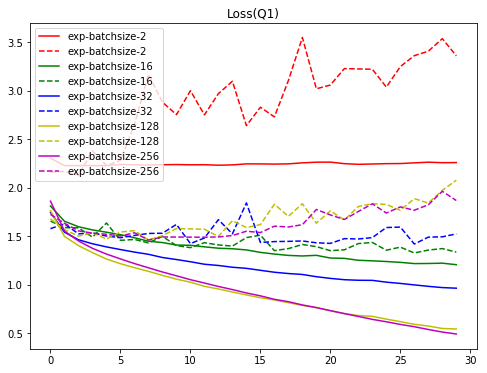

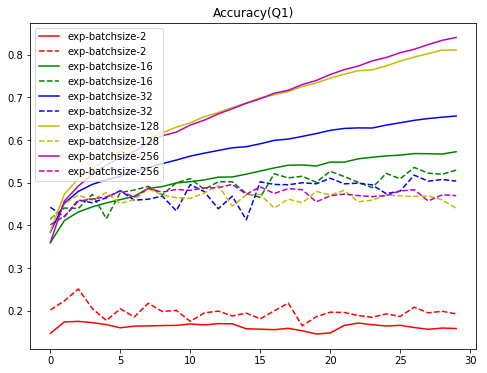

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss(Q1)")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy(Q1)")
plt.legend()
plt.show()

In [9]:
# 2.請嘗試將 BN 放在 Activation 之前，並比較訓練結果
BATCH_SIZE = 1024
model = build_mlp2(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_16 (Batc (None, 128)               512       
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,739,402
Trainable params: 1,739,146
Non-trainable params: 256
________________________________________________________________

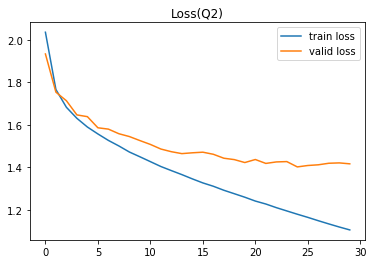

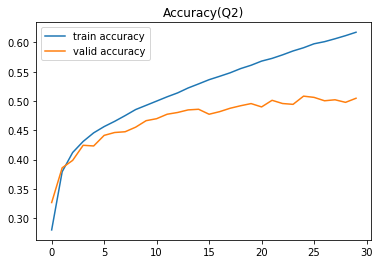

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss(Q2)")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy(Q2)")
plt.show()

In [11]:
# 3.請將 BN 放在 Input Layer 後，並比較結果
BATCH_SIZE = 1024
model = build_mlp3(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 3s 63us/step - loss: 2.2

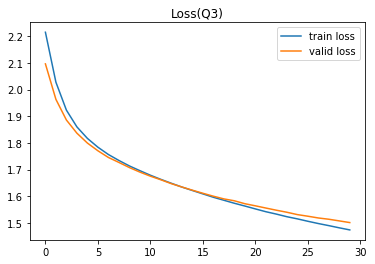

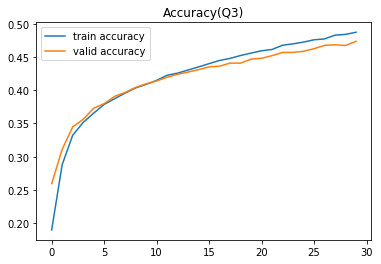

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss(Q3)")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy(Q3)")
plt.show()